# Library

In [1]:
#Library
import sys
import os
import os.path as pth

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import argparse
import itertools
from tqdm import tqdm
from quantization import *

import nets
import datasets
import tools
import layers as L

#!pip install torchplot

import torchplot as plt
import math
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# Main function

In [4]:
network = "resnet18"
dataset = "cifar10"

## Train function

In [5]:
# Train function
def train(model, trainloader, testloader, args):
    log = tools.StatLogger(args.log_path)

    # ===================================
    # initialize and run training session
    # ===================================
    # model.cuda()
    lossfunc = nn.CrossEntropyLoss()#.cuda()
    optimizer = optim.SGD(model.parameters(), lr=args.base_lr, momentum=0.9, weight_decay=args.weight_decay)

    # retrive pruning masks
    weight_masks = retrieve_masks(model)

    # Apply quantization
    index = 0
    for n, m in model.named_modules():
        if SFCL:
            if isinstance(m, nn.Linear):
                m.weight.data = quantize(m.weight.data, torch.max(torch.abs(m.weight.data)).item())
                index += 1
        if isinstance(m, nn.Conv2d):
            if m.kernel_size == (3, 3):
                m.weight.data = quantize(m.weight.data, torch.max(torch.abs(m.weight.data)).item())
                index += 1

    # Retraining steps
    for epoch in range(args.retraining_epochs):
        epoch += 1
        model.train()
        error_top1 = []
        error_top5 = []
        running_loss = []

        for idx, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = lossfunc(outputs, labels)
            loss.backward()

            optimizer.step()

            # get masked weights
            apply_mask(model, weight_masks)

            error_top1.append(tools.topK_error(outputs, labels, K=1).item())
            error_top5.append(tools.topK_error(outputs, labels, K=5).item())
            running_loss.append(loss.item())

        error_top1 = np.average(error_top1)
        error_top5 = np.average(error_top5)
        running_loss = np.average(running_loss)
        # print statistics
        print("RETRAIN epoch:%-4d error_top1: %.4f error_top5: %.4f loss:%.4f" % (
            epoch, error_top1, error_top5, running_loss))
        log.report(epoch=epoch,
                   split='RETRAIN',
                   error_top5=float(error_top5),
                   error_top1=float(error_top1),
                   loss=float(running_loss))

        # Quantize again
        index = 0
        for n, m in model.named_modules():
            if SFCL:
                if isinstance(m, nn.Linear):
                    m.weight.data = quantize(m.weight.data, torch.max(torch.abs(m.weight.data)).item())
                    index += 1
            if isinstance(m, nn.Conv2d):
                if m.kernel_size == (3, 3):
                    m.weight.data = quantize(m.weight.data, torch.max(torch.abs(m.weight.data)).item())
                    index += 1

        validate(model, testloader, lossfunc, log, epoch)

        print('-- saving model check point')
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
        }, os.path.join(args.checkpoint_dir, 'checkpoint_{}.tar'.format(epoch)))

    print('Finished Retraining')

## Validate function

In [6]:
# Validation function
def validate(model, testloader, lossfunc, log, epoch):
    print("-- running evaluation on validation split")
    model.eval()
    error_top1 = []
    error_top5 = []
    vld_loss = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            #inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            error_top1.append(tools.topK_error(outputs, labels, K=1).item())
            error_top5.append(tools.topK_error(outputs, labels, K=5).item())
            vld_loss.append(lossfunc(outputs, labels).item())

        error_top1 = np.average(error_top1)
        error_top5 = np.average(error_top5)
        vld_loss = np.average(vld_loss)
        print(
            "VALID epoch:%-4d error_top1: %.4f error_top5: %.4f loss:%.4f" % (epoch, error_top1, error_top5, vld_loss))
        log.report(epoch=epoch,
                   split='VALID',
                   error_top5=float(error_top5),
                   error_top1=float(error_top1),
                   loss=float(vld_loss))

# Quantization my model

In [7]:
# Need to modify original function
def getQlevels(bits=6):
    qlevels = [0]
    itertable = []
    for i in range(bits - 1):
        qlevels.extend((2 ** i, -2 ** i))
        itertable.extend((2 ** i, -2 ** i))
    itertable.extend((2 ** (bits - 1), -2 ** (bits - 1)))
    comb2 = list(itertools.combinations(itertable, 2))
    for item in comb2:
        val = item[0] + item[1]
        if 2 ** (bits - 1) > val > -(2 ** (bits - 1)):
            qlevels.append(val)
    qlevels = sorted(list(dict.fromkeys(qlevels)))
    return qlevels

# Actual quantization function (Some how related to getQlevels function)
def quantize(weights, bound):
    weight = weights.detach().flatten()
    weight[weight>bound] = bound
    weight[weight<-bound] = -bound
    alpha = bound/torch.max(_QLEVELS)
    alpha = 2**(torch.round(torch.log2(alpha)))

    # print("alpha: {:.4f}".format(alpha))
    #torch.cuda.empty_cache()
    idx = torch.argmin(torch.abs((weight/alpha).unsqueeze(0) - _QLEVELS.unsqueeze(1)), dim=0)
    weight_int = _QLEVELS[idx]
    weight_quant = weight_int.float() * alpha
    return weight_quant.reshape(weights.shape)

# CSD quantization with quant_bits = 6
# _QLEVELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 20, 24, 28, 30, 31,
#      -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -12, -14, -15, -16, -17, -18, -20, -24, -28, -30, -31]
# _QLEVELS = getQlevels(6)
# print(_QLEVELS)

_QLEVELS = [i for i in range(-31, 31)]
_QLEVELS = torch.tensor(_QLEVELS)#.cuda()

# Quantization function from Pierre

# Retrieve pruning masks
def retrieve_masks(model):
    num_pruned, num_weights = 0, 0
    weight_masks = []
    for m in model.modules():
        if SFCL:
            if isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3) or isinstance(m, nn.Linear):
                num = torch.numel(m.weight.data)
                weight_mask = (abs(m.weight.data) > 0).float()
                weight_masks.append(weight_mask)

                num_pruned += num - torch.sum(weight_mask)
                num_weights += num
        else:
            if isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3):
                num = torch.numel(m.weight.data)
                weight_mask = (abs(m.weight.data) > 0).float()
                weight_masks.append(weight_mask)

                num_pruned += num - torch.sum(weight_mask)
                num_weights += num

    # print('-- compress rate: %.4f' % (num_pruned / num_weights))
    return weight_masks

# Apply Mask
def apply_mask(model, weight_masks):
    idx = 0
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3):
            m.weight.data *= weight_masks[idx]
            idx += 1
        if SFCL:
            if isinstance(m, nn.Linear):
                if m.out_features >= 16:
                    m.weight.data *= weight_masks[idx]
                    idx += 1

# Get Q-levels (What is this?)
def getQlevels(bits=6):
    qlevels = [0]
    itertable = []
    for i in range(bits - 1):
        qlevels.extend((2 ** i, -2 ** i))
        itertable.extend((2 ** i, -2 ** i))
    itertable.extend((2 ** (bits - 1), -2 ** (bits - 1)))
    comb2 = list(itertools.combinations(itertable, 2))
    for item in comb2:
        val = item[0] + item[1]
        if 2 ** (bits - 1) > val > -(2 ** (bits - 1)):
            qlevels.append(val)
    qlevels = sorted(list(dict.fromkeys(qlevels)))
    return qlevels

# Actual quantization function (Some how related to getQlevels function)
def quantize(weights, bound):
    weight = weights.detach().flatten()
    weight[weight>bound] = bound
    weight[weight<-bound] = -bound
    alpha = bound/torch.max(_QLEVELS)
    alpha = 2**(torch.round(torch.log2(alpha)))

    # print("alpha: {:.4f}".format(alpha))
    #torch.cuda.empty_cache()
    idx = torch.argmin(torch.abs((weight/alpha).unsqueeze(0) - _QLEVELS.unsqueeze(1)), dim=0)
    weight_int = _QLEVELS[idx]
    weight_quant = weight_int.float() * alpha
    return weight_quant.reshape(weights.shape)

# CSD quantization with quant_bits = 6
# _QLEVELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 20, 24, 28, 30, 31,
#      -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -12, -14, -15, -16, -17, -18, -20, -24, -28, -30, -31]
# _QLEVELS = getQlevels(6)
# print(_QLEVELS)

_QLEVELS = [i for i in range(-31, 31)]
_QLEVELS = torch.tensor(_QLEVELS)#.cuda()

In [5]:
# Practice of above function
_QLEVELS = [i for i in range(-31, 31)]
_QLEVELS = torch.tensor(_QLEVELS)#.cuda()
a = torch.tensor([[31, 13], [1.2351, 1]])
weights = a
bound = 8
print(weights)
weight = weights.detach().flatten()
print(weight)
weight[weight>bound] = bound
print(weight)
weight[weight<-bound] = -bound
print(weight)

weight = weights.detach().flatten()
weight[weight>bound] = bound
weight[weight<-bound] = -bound
alpha = bound/torch.max(_QLEVELS)
alpha = 2**(torch.round(torch.log2(alpha)))

# print("alpha: {:.4f}".format(alpha))
#torch.cuda.empty_cache()
idx = torch.argmin(torch.abs((weight/alpha).unsqueeze(0) - _QLEVELS.unsqueeze(1)), dim=0)
weight_int = _QLEVELS[idx]
weight_quant = weight_int.float() * alpha


print(a)
c = quantize(a, 8)
print(c)

tensor([[31.0000, 13.0000],
        [ 1.2351,  1.0000]])
tensor([31.0000, 13.0000,  1.2351,  1.0000])
tensor([8.0000, 8.0000, 1.2351, 1.0000])
tensor([8.0000, 8.0000, 1.2351, 1.0000])
tensor([[8.0000, 8.0000],
        [1.2351, 1.0000]])
tensor([[7.5000, 7.5000],
        [1.2500, 1.0000]])


In [30]:
# Quant with 1 integer bit
def quant_signed_1(original, bit=6):
    bit = bit - 2
    original = original.clamp(max=1.9375,min=-1.9375)
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)


# Quant with no integer bit
def quant_signed_0(original, bit=6):
    bit = bit - 1
    original = original.clamp(max=0.96875,min=-0.96875)
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)

def quant_signed_15(original, bit=5):
    bit = bit - 2
    original = original.clamp(max=1.875,min=-1.875)
    #print("Activation result quantization")
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)


def quant_signed_05(original, bit=5):
    bit = bit - 1
    original = original.clamp(max=0.9375,min=-0.9375)
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)

In [35]:
a = torch.tensor([[0.5, 0.0234], [0.2351, 0.5]])
print(a)
quant_signed_0(a)

tensor([[0.5000, 0.0234],
        [0.2351, 0.5000]])


tensor([[0.50000, 0.00000],
        [0.21875, 0.50000]])

In [40]:
b = a.clamp(max=0.96875,min=-0.96875)
print(b)
b * (32)

tensor([[0.50000, 0.02340],
        [0.23510, 0.50000]])


tensor([[16.00000,  0.74880],
        [ 7.52320, 16.00000]])

In [47]:
a = torch.tensor([[0.01, 0.0234], [0.2351, 0.012]])
print(a)
c = quantize(a, 0.96875)
print(c)
print(c*32)
d = quant_signed_0(a)
print(d)
print(d*32)

tensor([[0.01000, 0.02340],
        [0.23510, 0.01200]])
tensor([[0.00000, 0.03125],
        [0.25000, 0.00000]])
tensor([[0., 1.],
        [8., 0.]])
tensor([[0.00000, 0.00000],
        [0.21875, 0.00000]])
tensor([[0., 0.],
        [7., 0.]])


In [28]:
7 / 32

0.21875

In [25]:
quant_signed_0(torch.tensor([[0.0234]]))

tensor([[0.]])

# Evaluation

In [13]:
# All function for evaulation
def dump_act(module, input, output):
    if len(output) > 0:
        input_act_list.append(input[0].detach().cpu().numpy())
        output_act_list.append(output[0].detach().cpu().numpy())

# Calculate weight density
def cal_density(model):
    num_pruned, num_weights = 0, 0
    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3):
            num = torch.numel(m.weight.data)
            weight_mask = (abs(m.weight.data) > 0).float()

            num_pruned += num - torch.sum(weight_mask)
            num_weights += num

    return 1 - num_pruned / num_weights

def eval(model, testloader):
    print("Running evaluation on validation split")
    model.eval()

    lossfunc = nn.CrossEntropyLoss().cuda()
    error_top1 = []
    error_top5 = []
    vld_loss = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            error_top1.append(tools.topK_error(outputs, labels, K=1).item())
            error_top5.append(tools.topK_error(outputs, labels, K=5).item())
            vld_loss.append(lossfunc(outputs, labels).item())

        error_top1 = np.average(error_top1)
        error_top5 = np.average(error_top5)
        vld_loss = np.average(vld_loss)
        print("-- Validation result -- acc_top1: %.4f acc_top5: %.4f loss:%.4f" % (1-error_top1, 1-error_top5, vld_loss))

def dump_batch(model, testloader, batch_size, arch):
    print("Dumping batch for simulation")
    for n, m in model.named_modules():
        # if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3):
        if isinstance(m, nn.Conv2d):
            if m.kernel_size == (3, 3):
                m.register_forward_hook(dump_act)
                weight_list.append(m.weight.data.detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs = data[0][0:batch_size, :, :, :]
            inputs = inputs.cuda()
            model(inputs)
            break

    for i in range(0, len(weight_list)):
        np.save("../py_sim_dump/{}/wgt-layer_{}.npy".format(arch, i), weight_list[i])
        np.save("../py_sim_dump/{}/act-layer_{}-{}.npy".format(arch, i, batch_size), input_act_list[i])

def main():
    args = parser.parse_args()

    if args.arch == 'resnet20':
        model = nets.RESNET20MULT3()
        pretrained_checkpoint = '../checkpoints/original/resnet20_ckpt.tar'
    if args.arch == 'vggnagamult':
        model = nets.VGGnagaMULT()
        pretrained_checkpoint = '../checkpoints/vggnagamult_quant_8bit_ckpt.tar'
    if args.arch == 'cnnc':
        model = nets.CNNCMULT3()
        pretrained_checkpoint = '../checkpoints/original/cnnc_ckpt.tar'
    if args.arch == 'cnnc-conv':
        model = nets.CNNC()
        pretrained_checkpoint = '../checkpoints/cnnc-conv_quant_8bit_ckpt.tar'
    if args.arch == 'vggnagacnn':
        model = nets.VGGnagaCNN()
        pretrained_checkpoint = '../checkpoints/vggnagacnn_unstructured_quant_8bit_sfcl_ckpt.tar'
    if args.arch == 'resnet18cnn':
        model = nets.RESNET18CNN()
        pretrained_checkpoint = '../quant_cnn_checkpoints/resnet18_cifar10/checkpoint_30.tar'
    if args.arch == 'resnet20cnn':
        model = nets.RESNET20CNN()
        pretrained_checkpoint = '../checkpoints/resnet20cnn_quant_8bit_ckpt.tar'

    model.cuda()

    # load pretrained checkpoint

    
    print("Loading checkpoint '{}'".format(pretrained_checkpoint))
    pretrained_ckpt = torch.load(pretrained_checkpoint)
    print(pretrained_ckpt)
    model.load_state_dict(pretrained_ckpt['state_dict'])
    print("Loaded checkpoint '{}'".format(pretrained_checkpoint))

    density = cal_density(model)
    print("-- Weight density after learning sparsity and CSD quantization: %.4f" % density)

    if args.dataset == 'cifar10':
        _, _, testloader = datasets.get_cifar10()
    if args.dataset == 'cifar100':
        _, _, testloader = datasets.get_cifar100()
    if args.dataset == 'imagenet':
        _, _, testloader = datasets.get_imagenet(args.dataset_dir)


    # dump_batch(model, testloader, 1, args.arch)
    eval(model, testloader)

## Weights values & plot

In [3]:
# Weights values and plot

import torchplot as plt

batch_size = 30
dataset = 'cifar10'
arch = 'CNN_627'
pretrained_checkpoint = './checkpoints_train/CNN_627_cifar10/Sun_Feb_12_15_59_00_2023/checkpoint_200.tar'
model = nets.CNN_627()


#model.cuda()

# load pretrained checkpoint

print("-----------------------------------------------------")
print("Loading checkpoint '{}'".format(pretrained_checkpoint))
print("-----------------------------------------------------")
pretrained_ckpt = torch.load(pretrained_checkpoint)
#print(pretrained_ckpt)
model.load_state_dict(pretrained_ckpt['state_dict'])

weights = pretrained_ckpt
#model.load_state_dict(pretrained_ckpt['state_dict'])
#print(pretrained_ckpt.keys())
#print("-----------------------------------------------------")
#print(pretrained_ckpt['state_dict'].keys())
for k in pretrained_ckpt['state_dict'].keys():
    print(k)
print("-----------------------------------------------------")
print(pretrained_ckpt['state_dict']['conv1_1.weight'].shape)
#print(pretrained_ckpt['state_dict']['conv1_1.weight'])
print("-----------------------------------------------------")
weight1 = pretrained_ckpt['state_dict']['conv1_1.weight']
weight2 = pretrained_ckpt['state_dict']['conv2_1.weight']
weight3 = pretrained_ckpt['state_dict']['conv3_1.weight']
weight4 = pretrained_ckpt['state_dict']['conv4_1.weight']
weight5 = pretrained_ckpt['state_dict']['fc5.weight']
weight6 = pretrained_ckpt['state_dict']['fc6.weight']

weight = [weight1, weight2, weight3, weight4, weight5, weight6]
print('     min max of conv layers weights')
print("-----------------------------------------------------")
print('         max               min')
for w in weight:
    max_num = -999
    min_num = 999
    print(torch.max(w).item(), torch.min(w).item())
t1 = torch.flatten(weight1)
t2 = torch.flatten(weight2)
t3 = torch.flatten(weight3)
t4 = torch.flatten(weight4)
t5 = torch.flatten(weight5)
#plt.plot(t1)
#plt.plot(t2)
#plt.plot(t3)
plt.plot(t4)
#plt.plot(t5)

-----------------------------------------------------
Loading checkpoint './checkpoints_train/CNN_627_cifar10/Sun_Feb_12_15_59_00_2023/checkpoint_200.tar'
-----------------------------------------------------


FileNotFoundError: [Errno 2] No such file or directory: './checkpoints_train/CNN_627_cifar10/Sun_Feb_12_15_59_00_2023/checkpoint_200.tar'

## Quantization Function

In [4]:
def getQlevels(bits=6):
    qlevels = [0]
    itertable = []
    for i in range(bits - 1):
        qlevels.extend((2 ** i, -2 ** i))
        itertable.extend((2 ** i, -2 ** i))
    itertable.extend((2 ** (bits - 1), -2 ** (bits - 1)))
    comb2 = list(itertools.combinations(itertable, 2))
    for item in comb2:
        val = item[0] + item[1]
        if 2 ** (bits - 1) > val > -(2 ** (bits - 1)):
            qlevels.append(val)
    qlevels = sorted(list(dict.fromkeys(qlevels)))
    return qlevels


def quantize(weights, bound):
    weight = weights.detach().flatten()
    weight[weight>bound] = bound
    weight[weight<-bound] = -bound
    alpha = bound/torch.max(_QLEVELS)
    alpha = 2**(torch.round(torch.log2(alpha)))

    # print("alpha: {:.4f}".format(alpha))
    #torch.cuda.empty_cache()
    idx = torch.argmin(torch.abs((weight/alpha).unsqueeze(0) - _QLEVELS.unsqueeze(1)), dim=0)
    weight_int = _QLEVELS[idx]
    weight_quant = weight_int.float() * alpha
    return weight_quant.reshape(weights.shape)
    
_QLEVELS = [i for i in range(-31, 31)]
_QLEVELS = torch.tensor(_QLEVELS)#.cuda()

In [5]:
Q = getQlevels()
a = torch.tensor([1,2,3, 0.15, 0.3])
b = [1,2,3]
quantize(a,2)

tensor([1.0000, 1.8750, 1.8750, 0.1250, 0.3125])

In [15]:
# Quantization function
# With 1bit for integer 
def quant_signed_1(original, bit=6):
    bit = bit-2
    a = original
    depth = len(a.shape)
    max_num = -999
    min_num = 999
    max_num = torch.max(a).item()
    min_num = torch.min(a).item()
    max_total = max(max_num, -min_num)
    #print(max_total)

    a = torch.flatten(a)
    length = len(a)
    output = []

    for i in range(len(a)):
        if a[i].item() >= 1:
            val = 1
        elif a[i].item() <= -1:
            val = -1
        else:
            val = math.trunc(a[i].item()*(2**bit))/(2**bit)
        output.append(val)

    output = torch.tensor(output, dtype=torch.float64)
    output = torch.reshape(output, original.shape)
    torch.set_printoptions(precision=bit)
    return output
    #print(output)
    #print(output * 2**bit)
    
# Without integer bit
def quant_signed_0(original, bit=6):
    bit = bit-1
    a = original

    a = torch.flatten(a)
    length = len(a)
    output = []

    for i in range(len(a)):
        if a[i].item() >= 0.96875:
            val = 0.96875
        elif a[i].item() <= -0.96875:
            val = -0.96875
        else:
            val = math.trunc(a[i].item()*(2**bit))/(2**bit)
        output.append(val)

    output = torch.tensor(output, dtype=torch.float64)
    output = torch.reshape(output, original.shape)
    torch.set_printoptions(precision=bit)
    output = output.float()
    return output
    #print(output)
    #print(output * 2**bit)


In [23]:
# Quant with 1 integer bit
def quant_signed_1(original, bit=6):
    bit = bit - 2
    original = original.clamp(max=1.9375,min=-1.9375)
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)


# Quant with no integer bit
def quant_signed_0(original, bit=6):
    bit = bit - 1
    original = original.clamp(max=0.96875,min=-0.96875)
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)

def quant_signed_15(original, bit=5):
    bit = bit - 2
    original = original.clamp(max=1.875,min=-1.875)
    #print("Activation result quantization")
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)


def quant_signed_05(original, bit=5):
    bit = bit - 1
    original = original.clamp(max=0.9375,min=-0.9375)
    torch.set_printoptions(precision=bit)
    return ((original * (2**bit)).int()) / (2**bit)

In [240]:
# Just an example of some function
weight = [weight5, weight6]
print('     min max of fc layers weights')
print("-----------------------------------------------------")
print('         max               min')
for w in weight:
    max_num = -999
    min_num = 999
    #print(len(w))
    for i in w:
        #print(i)
        num = i[0].item()
        max_num = max(max_num,num)
        min_num = min(min_num,num)
    #print(max_num, min_num)
print("-----------------------------------------------------")

     min max of fc layers weights
-----------------------------------------------------
         max               min
-----------------------------------------------------


In [15]:
density = cal_density(model)
print("-- Weight density after learning sparsity and CSD quantization: %.4f" % density)

-- Weight density after learning sparsity and CSD quantization: 0.6584


In [ ]:
if args.dataset == 'cifar10':
    _, _, testloader = datasets.get_cifar10()
if args.dataset == 'cifar100':
    _, _, testloader = datasets.get_cifar100()
if args.dataset == 'imagenet':
    _, _, testloader = datasets.get_imagenet(args.dataset_dir)


# dump_batch(model, testloader, 1, args.arch)
eval(model, testloader)
    
    

In [ ]:
    

# load pretrained checkpoint
if args.pretrained_weights is not None:
    print("Loading checkpoint '{}'".format(args.pretrained_weights))
    pretrained_ckpt = torch.load(args.pretrained_weights)
    model.load_state_dict(pretrained_ckpt['state_dict'])
    print("Loaded checkpoint '{}'".format(args.pretrained_weights))

# setup checkpoint directory
if not pth.exists(args.checkpoint_dir):
    os.makedirs(args.checkpoint_dir)

train(model, trainloader, testloader, args)

# Post-Quantization training

In [10]:
# Post-Quantization old function
# CSD quantization with quant_bits = 6
# _QLEVELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 20, 24, 28, 30, 31,
#      -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -12, -14, -15, -16, -17, -18, -20, -24, -28, -30, -31]
# _QLEVELS = getQlevels(6)
# print(_QLEVELS)

_QLEVELS = [i for i in range(-31, 31)]
_QLEVELS = torch.tensor(_QLEVELS)#.cuda()

# Retrieve pruning masks
def retrieve_masks(model):
    num_pruned, num_weights = 0, 0
    weight_masks = []
    for m in model.modules():
        if SFCL:
            if isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3) or isinstance(m, nn.Linear):
                num = torch.numel(m.weight.data)
                weight_mask = (abs(m.weight.data) > 0).float()
                weight_masks.append(weight_mask)

                num_pruned += num - torch.sum(weight_mask)
                num_weights += num
        else:
            if isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3):
                num = torch.numel(m.weight.data)
                weight_mask = (abs(m.weight.data) > 0).float()
                weight_masks.append(weight_mask)

                num_pruned += num - torch.sum(weight_mask)
                num_weights += num

    # print('-- compress rate: %.4f' % (num_pruned / num_weights))
    return weight_masks


def apply_mask(model, weight_masks):
    idx = 0
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, L.MultLayer) or isinstance(m, L.MultLayer3):
            m.weight.data *= weight_masks[idx]
            idx += 1
        if SFCL:
            if isinstance(m, nn.Linear):
                if m.out_features >= 16:
                    m.weight.data *= weight_masks[idx]
                    idx += 1

def getQlevels(bits=6):
    qlevels = [0]
    itertable = []
    for i in range(bits - 1):
        qlevels.extend((2 ** i, -2 ** i))
        itertable.extend((2 ** i, -2 ** i))
    itertable.extend((2 ** (bits - 1), -2 ** (bits - 1)))
    comb2 = list(itertools.combinations(itertable, 2))
    for item in comb2:
        val = item[0] + item[1]
        if 2 ** (bits - 1) > val > -(2 ** (bits - 1)):
            qlevels.append(val)
    qlevels = sorted(list(dict.fromkeys(qlevels)))
    return qlevels


def quantize(weights, bound):
    weight = weights.detach().flatten()
    weight[weight>bound] = bound
    weight[weight<-bound] = -bound
    alpha = bound/torch.max(_QLEVELS)
    alpha = 2**(torch.round(torch.log2(alpha)))

    # print("alpha: {:.4f}".format(alpha))
    #torch.cuda.empty_cache()
    idx = torch.argmin(torch.abs((weight/alpha).unsqueeze(0) - _QLEVELS.unsqueeze(1)), dim=0)
    weight_int = _QLEVELS[idx]
    weight_quant = weight_int.float() * alpha
    return weight_quant.reshape(weights.shape)



def train(model, trainloader, testloader, args):
    log = tools.StatLogger(args.log_path)

    # ===================================
    # initialize and run training session
    # ===================================
    # model.cuda()
    lossfunc = nn.CrossEntropyLoss()#.cuda()
    optimizer = optim.SGD(model.parameters(), lr=args.base_lr, momentum=0.9, weight_decay=args.weight_decay)

    # retrive pruning masks
    weight_masks = retrieve_masks(model)

    # Apply quantization
    index = 0
    for n, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            if m.kernel_size == (3, 3):
                m.weight.data = quant_signed_1(m.weight.data, 6)
                index += 1

    # Retraining steps
    for epoch in range(args.retraining_epochs):
        epoch += 1
        model.train()
        error_top1 = []
        error_top5 = []
        running_loss = []

        for idx, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = lossfunc(outputs, labels)
            loss.backward()

            optimizer.step()

            # get masked weights
            apply_mask(model, weight_masks)

            error_top1.append(tools.topK_error(outputs, labels, K=1).item())
            error_top5.append(tools.topK_error(outputs, labels, K=5).item())
            running_loss.append(loss.item())

        error_top1 = np.average(error_top1)
        error_top5 = np.average(error_top5)
        running_loss = np.average(running_loss)
        # print statistics
        print("RETRAIN epoch:%-4d error_top1: %.4f error_top5: %.4f loss:%.4f" % (
            epoch, error_top1, error_top5, running_loss))
        log.report(epoch=epoch,
                   split='RETRAIN',
                   error_top5=float(error_top5),
                   error_top1=float(error_top1),
                   loss=float(running_loss))

        # Quantize again
        index = 0
        for n, m in model.named_modules():
            if isinstance(m, nn.Conv2d):
                if m.kernel_size == (3, 3):
                    m.weight.data = quant_signed_1(m.weight.data, 6)
                    index += 1

        validate(model, testloader, lossfunc, log, epoch)

        print('-- saving model check point')
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
        }, os.path.join(args.checkpoint_dir, 'checkpoint_{}.tar'.format(epoch)))

    print('Finished Retraining')


def validate(model, testloader, lossfunc, log, epoch):
    print("-- running evaluation on validation split")
    model.eval()
    error_top1 = []
    error_top5 = []
    vld_loss = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            #inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            error_top1.append(tools.topK_error(outputs, labels, K=1).item())
            error_top5.append(tools.topK_error(outputs, labels, K=5).item())
            vld_loss.append(lossfunc(outputs, labels).item())

        error_top1 = np.average(error_top1)
        error_top5 = np.average(error_top5)
        vld_loss = np.average(vld_loss)
        print(
            "VALID epoch:%-4d error_top1: %.4f error_top5: %.4f loss:%.4f" % (epoch, error_top1, error_top5, vld_loss))
        log.report(epoch=epoch,
                   split='VALID',
                   error_top5=float(error_top5),
                   error_top1=float(error_top1),
                   loss=float(vld_loss))
        
        
# Quantization function
# With 1bit for integer 
def quant_signed_1(original, bit):
    bit = bit-2
    a = original
    depth = len(a.shape)
    max_num = -999
    min_num = 999
    max_num = torch.max(a).item()
    min_num = torch.min(a).item()
    max_total = max(max_num, -min_num)
    #print(max_total)

    a = torch.flatten(a)
    length = len(a)
    output = []

    for i in range(len(a)):
        if a[i].item() >= 1:
            val = 1
        else:
            val = math.trunc(a[i].item()*(2**bit))/(2**bit)
        output.append(val)

    output = torch.tensor(output, dtype=torch.float64)
    output = torch.reshape(output, original.shape)
    torch.set_printoptions(precision=bit)
    return output
    #print(output)
    #print(output * 2**bit)
    
# Without integer bit
def quant_signed_0(original, bit=6):
    bit = bit-1
    a = original
    
    a = torch.flatten(a)
    length = len(a)
    output = []

    for i in range(len(a)):
        if a[i].item() >= 0.96875:
            val = 0.96875
        else:
            val = math.trunc(a[i].item()*(2**bit))/(2**bit)
        output.append(val)

    output = torch.tensor(output, dtype=torch.float64)
    output = torch.reshape(output, original.shape)
    torch.set_printoptions(precision=bit)
    return output
    #print(output)
    #print(output * 2**bit)


# Getting Data and Save it

## Cifar10

In [72]:
# Cifar10
batch_size=256
distributed=None
trainsampler = None
workers=2
print("Loading cifar10 data ... ")
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, 4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/tmpssd/pabillam/data', train=True, download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=(trainsampler is None), 
              num_workers=workers, pin_memory=True, sampler=trainsampler)

val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='/tmpssd/pabillam/data', train=False, download=True, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=workers, pin_memory=True)

Loading cifar10 data ... 
Files already downloaded and verified
Files already downloaded and verified


In [65]:
# Save train data
data_train = trainset[0]
label_train = trainset[1]

data_train = (data_train.int() - 128)/128
data_train = quant_signed_0(data_train)


with open("./data_quantized/quant_data.pkl","wb") as f:
    pickle.dump(data_train, f)
with open("./data_quantized/quant_label.pkl","wb") as g:
    pickle.dump(label_train, g)
    
    
# Save test data
label = testset[0]
data = testset[1]

data = (data.int() - 128)/128
data = quant_signed_0(data)
data = m(data)

with open("./data_quantized/quant_test_data.pkl","wb") as f:
    pickle.dump(data, f)
with open("./data_quantized/quant_test_label.pkl","wb") as g:
    pickle.dump(label, g)

AttributeError: 'tuple' object has no attribute 'int'

## MNIST

In [2]:
# MNIST
batch_size=256
distributed=None
trainsampler = None
workers=2

print("Loading MNIST data ... ")
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=(trainsampler is None), 
              num_workers=workers, pin_memory=True, sampler=trainsampler)

val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])
testset = torchvision.datasets.MNIST(root='./MNIST', train=False, download=True, transform=val_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=workers, pin_memory=True)

Loading MNIST data ... 


In [23]:
# Saving Data

# Padding
m = nn.ConstantPad2d(2, 0)


# Save train data
data_train = trainset.train_data
label_train = trainset.train_labels

data_train = (data_train.int()-128)/128
data_train = quant_signed_15(data_train)
data_train = m(data_train)

with open("./data_quantized/quant_data_mnist.pkl","wb") as f:
    pickle.dump(data_train, f)
with open("./data_quantized/quant_label_mnist.pkl","wb") as g:
    pickle.dump(label_train, g)
    
    
# Save test data
label = testset.test_labels
data = testset.test_data

data = (data.int()-128)/128
data = quant_signed_15(data)
data = m(data)

with open("./data_quantized/quant_test_data_mnist.pkl","wb") as f:
    pickle.dump(data, f)
with open("./data_quantized/quant_test_label_mnist.pkl","wb") as g:
    pickle.dump(label, g)

In [21]:
data[0][11]

tensor([ 0.000,  0.000, -0.500, -0.500, -0.500, -0.500, -0.500, -0.500, -0.125,
         0.000, -0.125,  0.000,  0.125,  0.375,  0.375,  0.375,  0.375,  0.375,
         0.375,  0.375,  0.375,  0.375,  0.375,  0.000, -0.500, -0.500, -0.500,
        -0.500, -0.500, -0.500,  0.000,  0.000])

In [387]:
# Quantized and save train set
from tqdm import tqdm
import pickle

data_list = []
label_list = []
for i in tqdm(trainset):
    data_a, index_b = i
    data_a = quant_signed_0(data_a)
    data_list.append(data_a)
    label_list.append(index_b)
    
with open("./data_quantized/quant_data_mnist.pkl","wb") as f:
    pickle.dump(data_list, f)
with open("./data_quantized/quant_label_mnist.pkl","wb") as g:
    pickle.dump(label_list, g)

  0%|                                                                                        | 0/60000 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

# Check data well distributed

In [420]:
a = data[0]
print(a)
print(quant_signed_0(a))
print(quant_signed_00(a))
print(quant_signed_0(a)==quant_signed_00(a))
print(quant_signed_1(a)==quant_signed_11(a))

tensor([[-1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000],
        [-1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000],
        [-1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000,
         -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000, -1.00000],
        [-1.00000, -1.00000, -1.00000, -1.00000, 

## Check the image after quantization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


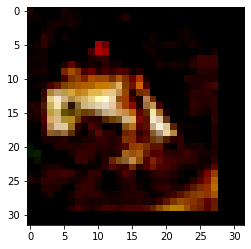

In [354]:
# Plot image
plt.imshow(quant_signed_00(trainset[0][0][0]))
img = trainset[0]
a = img[0].numpy()
a = a.transpose(1, 2, 0)
plt.imshow(a)

plt.imshow(trainset[0][0][0])
img = trainset[0]
a = img[0].numpy()
a = a.transpose(1, 2, 0)
plt.imshow(a)

## Quantizaion and save

In [399]:
data_list = quant_signed_0(trainset)

In [403]:
with open("./data_quantized/quant_data_mnist.pkl","wb") as f:
    pickle.dump(data_list, f)
with open("./data_quantized/quant_label_mnist.pkl","wb") as g:
    pickle.dump(label_list, g)

tensor([[-0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875],
        [-0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875],
        [-0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875,
         -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875, -0.96875],
        [-0.96875, -0.96875, -0.96875, -0.96875, 

In [804]:
# Quantized and save test set
from tqdm import tqdm
import pickle

data_list = []
label_list = []
for i in tqdm(testset):
    data_a, index_b = i
    data_a = quant_signed_0(data_a)
    data_list.append(data_a)
    label_list.append(index_b)
    
with open("./data_quantized/quant_test_data.pkl","wb") as w:
    pickle.dump(data_list, w)
    
with open("./data_quantized/quant_test_label.pkl","wb") as k:
    pickle.dump(label_list, k)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:52<00:00, 43.05it/s]


# Next level

In [821]:
try:
    ㄴㅇㄹ
except Exception  as e: 
    print(e)

name 'ᄂᄋᄅ' is not defined


In [841]:
file  = open('./latest.txt' , 'w' )
checkpoint_dir = '/123213/'
epoch = 100
file.write(os.path.join(checkpoint_dir, 'checkpoint_{}.tar'.format(epoch))) 
file.close()    

In [840]:
mon = time.localtime().tm_mon
day = time.localtime().tm_mday
hour = time.localtime().tm_hour
minu = time.localtime().tm_min


mon = str(mon)
day = str(day)
hour = str(hour)
minu = str(minu)
now = mon + "_" + day + "_Time_" + hour + "_" + minu


2 12 16 21


'2_12_Time_16_21'

In [829]:
now = time.ctime()
now

'Sun Feb 12 16:19:15 2023'

In [827]:
now = now.replace(":","_")
now = now.replace(" ","_")
now[4:16]

'Feb_12_16_18'

In [600]:
import random

a = random.sample(label_list,256)
b = random.sample(data_list,256)
torch.tensor(a)
torch.tensor(b)

ValueError: only one element tensors can be converted to Python scalars

In [632]:
ran = random.sample(range(50000),256)
a = []
b = torch.tensor([])
for i in ran:
    a = data_list[i]
    b = torch.cat((b,a),0)
b[1]

tensor([[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
        [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
        [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
        ...,
        [0.56250, 0.56250, 0.56250,  ..., 0.00000, 0.00000, 0.00000],
        [0.53125, 0.56250, 0.59375,  ..., 0.00000, 0.00000, 0.00000],
        [0.53125, 0.53125, 0.53125,  ..., 0.00000, 0.00000, 0.00000]])

In [645]:
b = torch.cat((random.sample(data_list,256)),0)
b[1].shape

torch.Size([32, 32])

In [641]:
d = random.sample(data_list,256)
d[0].shape

torch.Size([3, 32, 32])

In [652]:
a = d[0]
torch.cat((d[0],d[1]),1)[0]

tensor([[0.00000, 0.00000, 0.00000,  ..., 0.65625, 0.65625, 0.65625],
        [0.00000, 0.00000, 0.00000,  ..., 0.65625, 0.65625, 0.65625],
        [0.00000, 0.00000, 0.00000,  ..., 0.65625, 0.65625, 0.65625],
        ...,
        [0.00000, 0.00000, 0.00000,  ..., 0.15625, 0.15625, 0.15625],
        [0.00000, 0.00000, 0.00000,  ..., 0.18750, 0.15625, 0.15625],
        [0.00000, 0.00000, 0.00000,  ..., 0.18750, 0.18750, 0.15625]])

In [ ]:
torch

In [607]:
torch.rand(3,1)

tensor([[0.41399],
        [0.35471],
        [0.62400]])

In [599]:
a = [1, 2, 3]
torch.tensor([a,a])

tensor([[1, 2, 3],
        [1, 2, 3]])

In [661]:
a = d[0]
b = d[1]

In [678]:
c = [a,b]

In [680]:
d = torch.stack(c)
d.shape

torch.Size([2, 3, 32, 32])

In [668]:
a.shape

torch.Size([3, 32, 32])

In [676]:
my_tensor = torch.cat([a, b], dim=-0)

In [677]:
my_tensor[0].shape

torch.Size([32, 32])

In [681]:
d = torch.stack(random.sample(data_list,256))
d.shape

torch.Size([256, 3, 32, 32])

In [698]:
num = random.sample(range(50000),256)
data_num = []
label_num = []
for i in num:
    data_num.append(data_list[i])
    label_num.append(label_list[i])

In [762]:
data_num[0]

tensor([[[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
         [0.46875, 0.56250, 0.37500,  ..., 0.90625, 0.00000, 0.00000],
         [0.34375, 0.34375, 0.31250,  ..., 0.90625, 0.00000, 0.00000],
         ...,
         [0.53125, 0.53125, 0.50000,  ..., 0.43750, 0.00000, 0.00000],
         [0.50000, 0.50000, 0.53125,  ..., 0.46875, 0.00000, 0.00000],
         [0.53125, 0.56250, 0.56250,  ..., 0.43750, 0.00000, 0.00000]],

        [[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
         [0.50000, 0.59375, 0.40625,  ..., 0.90625, 0.00000, 0.00000],
         [0.34375, 0.37500, 0.34375,  ..., 0.90625, 0.00000, 0.00000],
         ...,
         [0.53125, 0.50000, 0.50000,  ..., 0.37500, 0.00000, 0.00000],
         [0.50000, 0.50000, 0.50000,  ..., 0.40625, 0.00000, 0.00000],
         [0.50000, 0.50000, 0.50000,  ..., 0.37500, 0.00000, 0.00000]],

        [[0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
         [0.46875, 0.53125, 0.34375,  ..., 0.

In [728]:
now = time.ctime()
now = now.replace(":","_")
now = now.replace(" ","_")
now[:13]

'Sun_Feb_12_03'

In [753]:
divmod(18,15)

(1, 3)

In [759]:
a = 0.043
print("%.f" % (a*1000))

43


In [742]:
time.ctime()[:13]

'Sun Feb 12 04'

In [724]:
a = str(a)[:4]

In [725]:
a

'0.23'

In [722]:
a[:4]

'0.23'

In [449]:
import pickle

with open("./quant_data.pkl","rb") as f:
    data_list = pickle.load(f)

In [450]:
data_list2

[]

In [416]:
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

testset = torchvision.datasets.CIFAR10(root='/tmpssd/pabillam/data', train=False, download=True, transform=val_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=workers, pin_memory=True)

Loading cifar10 data ... 
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for i in range(len(trainset)):
    trainset[i][0] = quant_signed_0(trainset[i][0])

tensor([[[15., 15., 16.,  ...,  0.,  0.,  0.],
         [16., 16., 17.,  ...,  0.,  0.,  0.],
         [15., 16., 17.,  ...,  0.,  0.,  0.],
         ...,
         [ 2.,  2.,  6.,  ...,  0.,  0.,  0.],
         [ 2.,  5., 14.,  ...,  0.,  0.,  0.],
         [ 3.,  7., 17.,  ...,  0.,  0.,  0.]],

        [[22., 22., 22.,  ...,  0.,  0.,  0.],
         [22., 23., 23.,  ...,  0.,  0.,  0.],
         [22., 23., 23.,  ...,  0.,  0.,  0.],
         ...,
         [10.,  9., 11.,  ...,  0.,  0.,  0.],
         [ 9., 11., 19.,  ...,  0.,  0.,  0.],
         [10., 13., 22.,  ...,  0.,  0.,  0.]],

        [[27., 27., 27.,  ...,  0.,  0.,  0.],
         [28., 28., 28.,  ...,  0.,  0.,  0.],
         [27., 27., 28.,  ...,  0.,  0.,  0.],
         ...,
         [14., 12., 14.,  ...,  0.,  0.,  0.],
         [14., 15., 22.,  ...,  0.,  0.,  0.],
         [14., 18., 26.,  ...,  0.,  0.,  0.]]], dtype=torch.float64)

In [381]:
b = quant_signed_0(trainset[1][0])

In [391]:
trainset2 = trainset1
trainset1 = trainset2

In [386]:
quant_signed_0(trainset[1][0])

tensor([[[0.59375, 0.46875, 0.40625,  ..., 0.34375, 0.31250, 0.28125],
         [0.53125, 0.56250, 0.46875,  ..., 0.37500, 0.28125, 0.25000],
         [0.53125, 0.53125, 0.43750,  ..., 0.28125, 0.25000, 0.25000],
         ...,
         [0.65625, 0.59375, 0.59375,  ..., 0.15625, 0.21875, 0.34375],
         [0.62500, 0.59375, 0.59375,  ..., 0.37500, 0.46875, 0.50000],
         [0.62500, 0.59375, 0.62500,  ..., 0.53125, 0.53125, 0.53125]],

        [[0.68750, 0.53125, 0.40625,  ..., 0.34375, 0.34375, 0.31250],
         [0.62500, 0.59375, 0.46875,  ..., 0.37500, 0.31250, 0.28125],
         [0.59375, 0.56250, 0.43750,  ..., 0.31250, 0.25000, 0.25000],
         ...,
         [0.62500, 0.59375, 0.62500,  ..., 0.12500, 0.18750, 0.31250],
         [0.59375, 0.59375, 0.62500,  ..., 0.34375, 0.43750, 0.46875],
         [0.56250, 0.56250, 0.59375,  ..., 0.50000, 0.50000, 0.50000]],

        [[0.71875, 0.53125, 0.34375,  ..., 0.25000, 0.25000, 0.25000],
         [0.65625, 0.59375, 0.43750,  ..., 0.

In [389]:
b = quant_signed_0(trainset[1][0])
b

tensor([[[0.59375, 0.46875, 0.40625,  ..., 0.34375, 0.31250, 0.28125],
         [0.53125, 0.56250, 0.46875,  ..., 0.37500, 0.28125, 0.25000],
         [0.53125, 0.53125, 0.43750,  ..., 0.28125, 0.25000, 0.25000],
         ...,
         [0.65625, 0.59375, 0.59375,  ..., 0.15625, 0.21875, 0.34375],
         [0.62500, 0.59375, 0.59375,  ..., 0.37500, 0.46875, 0.50000],
         [0.62500, 0.59375, 0.62500,  ..., 0.53125, 0.53125, 0.53125]],

        [[0.68750, 0.53125, 0.40625,  ..., 0.34375, 0.34375, 0.31250],
         [0.62500, 0.59375, 0.46875,  ..., 0.37500, 0.31250, 0.28125],
         [0.59375, 0.56250, 0.43750,  ..., 0.31250, 0.25000, 0.25000],
         ...,
         [0.62500, 0.59375, 0.62500,  ..., 0.12500, 0.18750, 0.31250],
         [0.59375, 0.59375, 0.62500,  ..., 0.34375, 0.43750, 0.46875],
         [0.56250, 0.56250, 0.59375,  ..., 0.50000, 0.50000, 0.50000]],

        [[0.71875, 0.53125, 0.34375,  ..., 0.25000, 0.25000, 0.25000],
         [0.65625, 0.59375, 0.43750,  ..., 0.

In [301]:
trainset[1][0]

tensor([[[0.35294, 0.32549, 0.25490,  ..., 0.00000, 0.00000, 0.00000],
         [0.34510, 0.38039, 0.27059,  ..., 0.00000, 0.00000, 0.00000],
         [0.27059, 0.36863, 0.35294,  ..., 0.00000, 0.00000, 0.00000],
         ...,
         [0.54902, 0.52549, 0.45490,  ..., 0.00000, 0.00000, 0.00000],
         [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
         [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000]],

        [[0.36471, 0.33725, 0.26275,  ..., 0.00000, 0.00000, 0.00000],
         [0.35686, 0.39216, 0.28235,  ..., 0.00000, 0.00000, 0.00000],
         [0.28627, 0.38039, 0.36471,  ..., 0.00000, 0.00000, 0.00000],
         ...,
         [0.50980, 0.49804, 0.44314,  ..., 0.00000, 0.00000, 0.00000],
         [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
         [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000]],

        [[0.29412, 0.27451, 0.21176,  ..., 0.00000, 0.00000, 0.00000],
         [0.27451, 0.31373, 0.21569,  ..., 0.

In [77]:
model = nets.CNN_627()
pretrained_weights = './train_checkpoints/{}_{}/checkpoint_100.tar'.format(network, dataset)
checkpoint_dir = './quant_cnn_checkpoints/{}_{}/'.format(network, dataset)
batch_size = 32
retraining_epochs = 30
base_lr = 0.001
weight_decay = 1e-4
log_path = './logs/{}_{}/quant_cnn.log'.format(network, dataset)

print(pretrained_weights)
print(checkpoint_dir)

./train_checkpoints/CNN_627_cifar10/checkpoint_100.tar
./quant_cnn_checkpoints/CNN_627_cifar10/


In [78]:
# load pretrained checkpoint
print("Loading checkpoint '{}'".format(pretrained_weights))
pretrained_ckpt = torch.load(pretrained_weights)
print(pretrained_ckpt.keys())
print(pretrained_ckpt['state_dict'].keys())

Loading checkpoint './train_checkpoints/CNN_627_cifar10/checkpoint_100.tar'
dict_keys(['epoch', 'state_dict'])
odict_keys(['conv1_1.weight', 'conv1_1.bias', 'conv2_1.weight', 'conv2_1.bias', 'conv3_1.weight', 'conv3_1.bias', 'conv4_1.weight', 'conv4_1.bias', 'fc6.weight', 'fc6.bias', 'fc7.weight', 'fc7.bias'])


In [79]:
model.load_state_dict(pretrained_ckpt['state_dict'])
print("Loaded checkpoint '{}'".format(pretrained_weights))

# setup checkpoint directory
if not pth.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

Loaded checkpoint './train_checkpoints/CNN_627_cifar10/checkpoint_100.tar'


In [81]:
log = tools.StatLogger(log_path)

# ===================================
# initialize and run training session
# ===================================
model.cuda()
lossfunc = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=weight_decay)

# retrive pruning masks
weight_masks = retrieve_masks(model)

# Apply quantization
index = 0
for n, m in model.named_modules():
    if isinstance(m, nn.Conv2d):
        if m.kernel_size == (3, 3):
            m.weight.data = quant_signed_1(m.weight.data, 6)
            index += 1

In [82]:
model.parameters

<bound method Module.parameters of CNN_627(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=1024, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc7): Linear(in_features=64, out_features=10, bias=True)
)>

In [83]:
torch.cuda.is_available()
device = torch.device("cuda")
model.to(device)

CNN_627(
  (conv1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=1024, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc7): Linear(in_features=64, out_features=10, bias=True)
)

In [85]:
inputs, labels = data

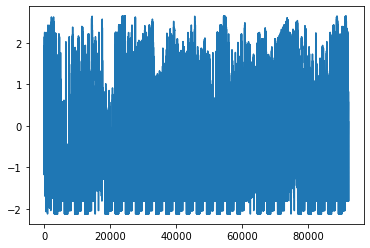

In [91]:
plt.plot(torch.flatten(inputs))

In [84]:
# Retraining steps
for epoch in range(retraining_epochs):
    epoch += 1
    model.train()
    error_top1 = []
    error_top5 = []
    running_loss = []

    for idx, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = lossfunc(outputs, labels)
        loss.backward()

        optimizer.step()

        # get masked weights
        apply_mask(model, weight_masks)

        error_top1.append(tools.topK_error(outputs, labels, K=1).item())
        error_top5.append(tools.topK_error(outputs, labels, K=5).item())
        running_loss.append(loss.item())

    error_top1 = np.average(error_top1)
    error_top5 = np.average(error_top5)
    running_loss = np.average(running_loss)
    # print statistics
    print("RETRAIN epoch:%-4d error_top1: %.4f error_top5: %.4f loss:%.4f" % (
        epoch, error_top1, error_top5, running_loss))
    log.report(epoch=epoch,
               split='RETRAIN',
               error_top5=float(error_top5),
               error_top1=float(error_top1),
               loss=float(running_loss))

    # Quantize again
    index = 0
    for n, m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            if m.kernel_size == (3, 3):
                m.weight.data = quant_signed_1(m.weight.data, 6)
                index += 1

    validate(model, testloader, lossfunc, log, epoch)

    print('-- saving model check point')
    torch.save({
        'epoch': epoch,
        'state_dict': model.state_dict(),
    }, os.path.join(checkpoint_dir, 'checkpoint_{}.tar'.format(epoch)))

print('Finished Retraining')

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.DoubleTensor) should be the same

In [282]:
import time

In [287]:
now = time.ctime()
now.replace(":","_")

'Sat Feb 11 23_46_58 2023'

In [288]:
now

'Sat Feb 11 23:46:58 2023'